In [1]:
import numpy as np
import processingIO as pio
import matplotlib.pyplot as plt
import pandas as pd

from pathlib import Path
from dataUtilities import filterData
from forceClass import Forces
from forceBinsClass import ForceBins

from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats.distributions import  t

from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

In [2]:
def power_law(xData, a, b, c):
        return a + (b * xData) + (c * xData**2)

def fit_data(xData, yData):

    popt, pcov = curve_fit(power_law, xData, yData, p0=[0.5, 0.5, 0.5])

    residuals = yData - power_law(xData, *popt)

    ss_res = np.sum(residuals**2)
    ss_total = np.sum((yData-np.mean(yData))**2)

    r_squared = 1 - (ss_res/ss_total)

    return popt, r_squared

In [3]:
data_location = r'/home/mco143/Documents/Current_OpenFOAM_Simulations/fish_amplitude0_20'

force_paths = pio.get_files(data_location, 'force.dat')
force_paths.sort()
forceBins_paths = pio.get_files(data_location, 'forceBin.dat')
forceBins_paths.sort()

# get the individual cases
cases = []
forceBin_case = forceBins_paths[0].parts[-7]
cases.append(forceBin_case)
for forceBins_file in forceBins_paths:
    if forceBins_file.parts[-7] != forceBin_case:
        cases.append(forceBins_file.parts[-7])
        forceBin_case = forceBins_file.parts[-7]

# get the all the folders inside the cases
strouhals = []
for forceBins_file in forceBins_paths:
    if forceBins_file.parts[-7] == cases[0]:
        strouhals.append(forceBins_file.parts[-6])
    else:
        break

# make a nice dict of all the file names based on parent case
caseDict = dict()
for parent_case in ('Forces', 'ForceBins'):
    caseDict[parent_case] = {}
    for case in cases:
        caseDict[parent_case][case] = {}
        for forceBins_file in forceBins_paths:
            if forceBins_file.parts[-7] == case:
                caseDict[parent_case][case][forceBins_file.parts[-6]] = forceBins_file

#forces = [Forces(filepath, cycles, total_cycles, True, True) for filepath in force_paths]

In [4]:
forces = [Forces(force_path, 2.0, 3.0, True, True) for force_path in force_paths]
forceBins = [ForceBins(forceBin_path, 2.0, 3.0, True, True) for forceBin_path in forceBins_paths]

In [5]:
omega = [1.571, 3.142, 7.854, 15.708, 23.562, 31.416]
for forceBin in forceBins:
    if forceBin.specific_case == 'st0_05':
        forceBin.calcPowerCarangiform(1025, np.array([0.02, -0.08, 0.16]), omega[0], 6.28)
    elif forceBin.specific_case == 'st0_10':
        forceBin.calcPowerCarangiform(1025, np.array([0.02, -0.08, 0.16]), omega[1], 6.28)
    elif forceBin.specific_case == 'st0_25':
        forceBin.calcPowerCarangiform(1025, np.array([0.02, -0.08, 0.16]), omega[2], 6.28)
    elif forceBin.specific_case == 'st0_50':
        forceBin.calcPowerCarangiform(1025, np.array([0.02, -0.08, 0.16]), omega[3], 6.28)
    elif forceBin.specific_case == 'st0_75':
        forceBin.calcPowerCarangiform(1025, np.array([0.02, -0.08, 0.16]), omega[4], 6.28)
    elif forceBin.specific_case == 'st1_00':
        forceBin.calcPowerCarangiform(1025, np.array([0.02, -0.08, 0.16]), omega[5], 6.28)


In [6]:
density = 1025

average_power_dict = {}
for case in caseDict['ForceBins']:
    average_power_dict[case] = []
    for forceBin in forceBins:
        if forceBin.parent_case == case:
            average_power_dict[case].append(forceBin.average_power)

average_force_dict = {}
for case in caseDict['Forces']:
    average_force_dict[case] = []
    for force in forces:
        if force.parent_case == case:
            average_force_dict[case].append(force.averageFilteredForces['total']['x']/density)

In [7]:
average_power_fit = {}
average_force_fit = {}
zero_strouhal = {}

st = np.array([0.05, 0.10, 0.25, 0.50, 0.75, 1.00])
Re = np.array([4e1, 4e2, 4e3, 4e4, 4e5, 4e6, 4e7, 4e8, 4e9, 4e10])

for case in caseDict['ForceBins']:
    average_power_fit[case] = {}
    average_force_fit[case] = {}
    
    case_power_fit, case_power_r_squared = fit_data(st, np.array(average_power_dict[case]))
    average_power_fit[case]['fit'] = case_power_fit
    average_power_fit[case]['r-squared'] = case_power_r_squared

    case_force_fit, case_force_r_squared = fit_data(np.array(average_force_dict[case]), st)
    average_force_fit[case]['fit'] = case_force_fit
    average_force_fit[case]['r-squared'] = case_force_r_squared
 
    zero_strouhal[case] = power_law(0, *case_force_fit)

/home/mco143/.local/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


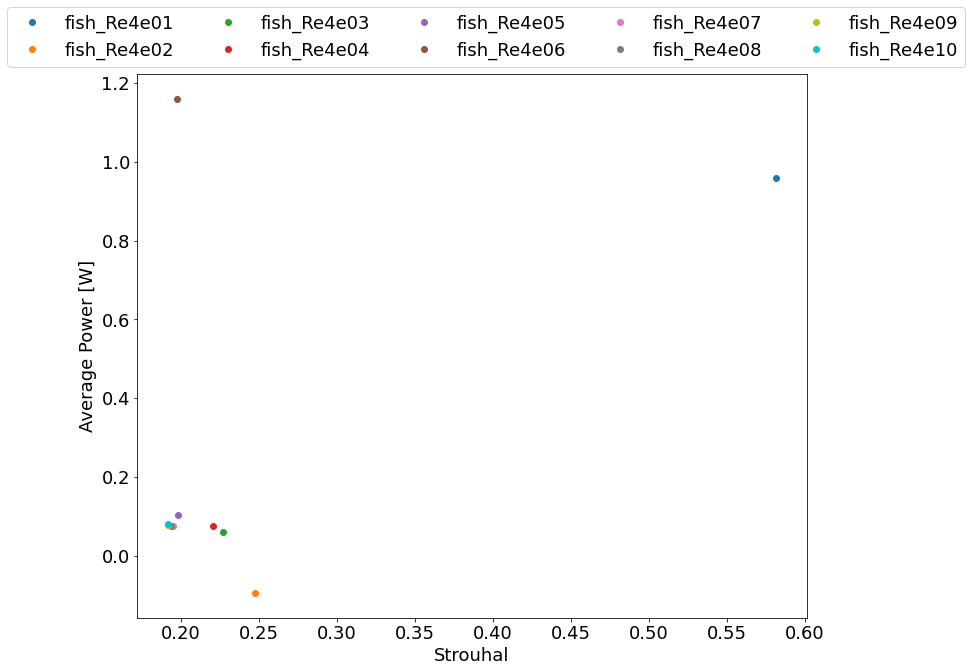

In [12]:
plt.rcParams.update({'font.size':18})
figure_location = r'/home/mco143/Documents/gitRepos/IkaFlow/OpenFOAM/figures'


fig2, ax2 = plt.subplots(figsize=(12,10))
for case in caseDict['ForceBins']:
    ax2.plot(zero_strouhal[case], power_law(zero_strouhal[case], *average_power_fit[case]['fit']), 'o', label = case)

ax2.set_xlabel('Strouhal')
ax2.set_ylabel('Average Power [W]')
ax2.legend(ncol=5, bbox_to_anchor=(1.25, 1.14))
fig2.savefig(Path(figure_location).joinpath('AvgPower_St.png'))

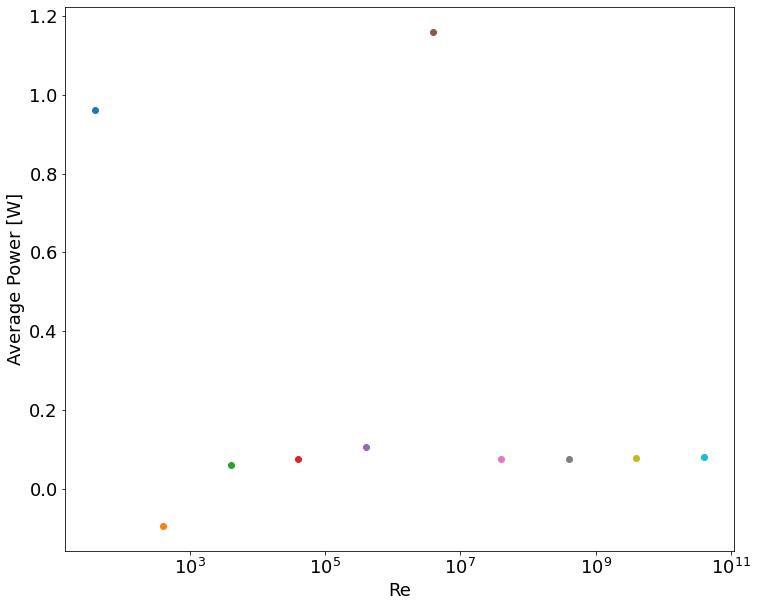

In [13]:
fig3, ax3 = plt.subplots(figsize=(12,10))
for i, case in enumerate(caseDict['ForceBins']):
    ax3.plot(Re[i], power_law(zero_strouhal[case], *average_power_fit[case]['fit']), 'o')

ax3.set_xscale('log')
ax3.set_xlabel('Re')
ax3.set_ylabel('Average Power [W]')
fig3.savefig(Path(figure_location).joinpath('AvgPower_Re.png'))

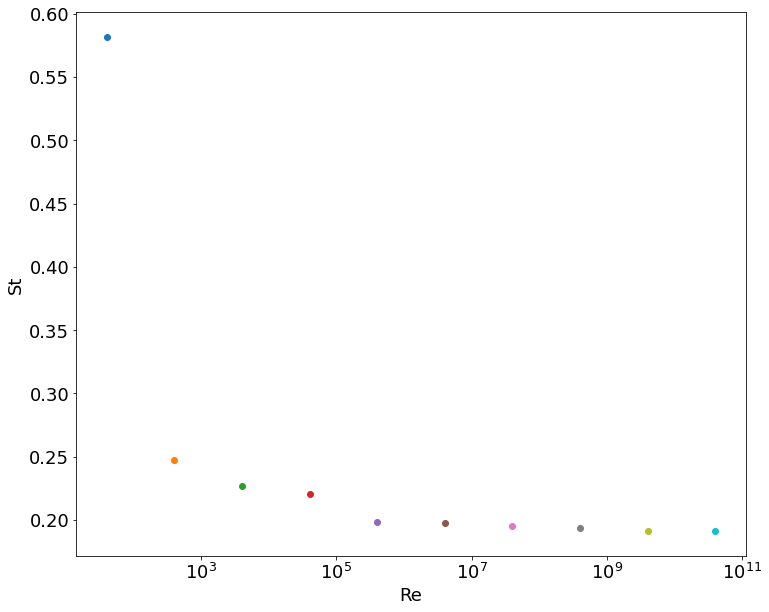

In [14]:
fig4, ax4 = plt.subplots(figsize=(12,10))
for i, case in enumerate(caseDict['ForceBins']):
    ax4.plot(Re[i], zero_strouhal[case], 'o')

ax4.set_xscale('log')
ax4.set_xlabel('Re')
ax4.set_ylabel('St')
fig4.savefig(Path(figure_location).joinpath('Re_St.png'))

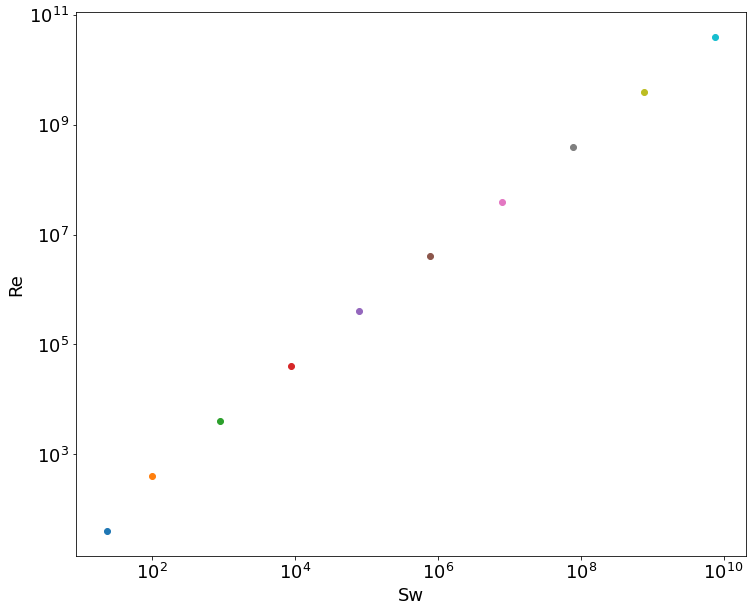

In [15]:
fig5, ax5 = plt.subplots(figsize=(12,10))
for i, case in enumerate(caseDict['ForceBins']):
    Sw = zero_strouhal[case] * Re[i]
    ax5.plot(Sw, Re[i], 'o')

ax5.set_yscale('log')
ax5.set_xscale('log')
ax5.set_xlabel('Sw')
ax5.set_ylabel('Re')
fig5.savefig(Path(figure_location).joinpath('Sw_Re.png'))